In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from tqdm import trange

In [9]:
def compare(x, y, eps2):
    '''
    Функция, которая сравнивает текущую и предыдущую итерацию
    
    Parameters
    ----------
    x: ndarray, shape (n,)
        Профиль мнений на текущей итерации, состоящий из n агентов
    y: ndarray, shape (n,)
        Профиль мнений на предыдущей итерации, состоящий из n агентов
    eps2: float
        Допустимая точность
        
    Returns
    -------
    result: bool
        True, если произошла "заморозка" модели
        False, если "заморозки" не произошло
    '''
    
    result = 1
    for k in range(len(x)):
        if abs(x[k] - y[k]) >= eps2:
            result = 0
    result = bool(result)
    return result


def Hen_Kr_dynamic_speed(x0, eps, eps2, fix):
    X = [np.array(x0)]
    t = 0
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            buf_data, count = new_op(X[t - 1], j, eps)
            if j not in fix:
                X[t][j] = buf_data
            else:
                v_cur = eps / count
                if X[t - 1][j] + v_cur <= 1:
                    X[t][j] = X[t - 1][j] + v_cur
                else:
                    X[t][j] = 1
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t


def Hen_Kr_dynamic_speed_consensus_statistics(x0, eps, eps2, fix):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            buf_data, count = new_op(X[t - 1], j, eps)
            if j != fix:
                X[t][j] = buf_data
            else:
                v_cur = eps / count
                if X[t - 1][j] + v_cur <= 1:
                    X[t][j] = X[t - 1][j] + v_cur
                else:
                    X[t][j] = 1
        if consensus_flag and is_consensus(X[t], fix):
            consensus_flag = False
            consensus_time = t
            consensus_value = X[t][0]
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time


def agents_under_target_agent(x, target_ind):
    count = 0
    for i in range(len(x)):
        if x[target_ind] > x[i]:
            count += 1
    return count


def new_op(x, i, eps):
    count = 1
    summ = x[i]
    for k in range(len(x)):
        if (abs(x[i] - x[k]) < eps) and (i != k):
            # print(i, j, x[i], x[j])
            summ += x[k]
            count += 1
    # print(summ, count)
    return summ/count, count


def find_dynamic_index(x0, spy_op):
    buf = x0.copy()
    for j in range(len(x0)):
        if buf[j] >= spy_op:
            buf = np.insert(buf, j, spy_op)
            return buf, j
        
        
def is_consensus(x, fix):
    for i in range(1, fix):
        if x[i-1] != x[i]:
            return False
    if x[fix - 1] != x[fix + 1]:
        return False
    for i in range(fix + 2, len(x)):
        if x[i-1] != x[i]:
            return False
    return True


def Hen_Kr_dynamic_speed_consensus_statistics_mod(x0, eps, eps2, fix):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            buf_data, count = new_op(X[t - 1], j, eps)
            if j != fix:
                X[t][j] = buf_data
            else:
                agents_below = agents_under_target_agent(X[t-1], fix)
#                 print(agents_below)
                v_cur = eps / (agents_below + 1)
                if X[t - 1][j] + v_cur <= 1:
                    X[t][j] = X[t - 1][j] + v_cur
                else:
                    X[t][j] = 1
        if consensus_flag and is_consensus(X[t], fix):
            consensus_flag = False
            consensus_time = t
            consensus_value = X[t][0]
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time


def Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, fix, prob):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=len(x0)-1)
        active_mask = np.insert(active_mask, fix, 1)
        t += 1
        for j in range(len(x0)):
            if j != fix and active_mask[j]==1:
                X_prev = np.copy(X[t - 1])
                X_prev[active_mask==0] = 0 - 2*eps - 2*eps2 
                X[t][j], count = new_op(X_prev, j, eps)
                X[t][active_mask==0] = X[t-1][active_mask==0]
            if j == fix:
                X_prev = np.copy(X[t - 1])
                X_prev[active_mask==0] = 0 - 2*eps - 2*eps2 
                count = agents_under_target_agent(X_prev, fix) - 1
                if count != 0:
                    v = (eps / count) * prob
                    if X[t - 1][j] + v <= 1:
                        X[t][j] = X[t - 1][j] + v
                    else:
                        X[t][j] = 1
                else:
                    X[t][j] = X[t-1][j]
        cl = clusters(X[t], eps, fix = {fix})
        if consensus_flag and len(cl) == 1:
            consensus_flag = False
            consensus_time = t
            consensus_value = cl[0]
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time


def Hen_Kr_actm2_dynamic_speed_control_statistic(x0, eps, eps2, fix, prob):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=len(x0)-1)
        active_mask = np.insert(active_mask, fix, 1)
        t += 1
        for j in range(len(x0)):
            if j != fix and active_mask[j]==1:
                X_prev = np.copy(X[t - 1])
                X_prev[active_mask==0] = 0 - 2*eps - 2*eps2 
                X[t][j], count = new_op(X_prev, j, eps)
                X[t][active_mask==0] = X[t-1][active_mask==0]
            if j == fix:
                _, count = new_op(X[t-1], j, eps)
                if count != 0:
                    v = (eps / count) * prob
                    if X[t - 1][j] + v <= 1:
                        X[t][j] = X[t - 1][j] + v
                    else:
                        X[t][j] = 1
                else:
                    X[t][j] = X[t-1][j]
        cl = clusters(X[t], eps, fix = {fix})
        if consensus_flag and len(cl) == 1:
            consensus_flag = False
            consensus_time = t
            consensus_value = cl[0]
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time


def clusters(x0, eps2, fix = {}):
    count = [x0[0]]
    l=0
    for i in range(1,len(x0)):
        if i not in fix:
            for j in range (len(count)):
                if np.abs(x0[i] - count[j])<eps2:
                    l+=1
            if l==0:
                count.append(x0[i])
            l=0
    return count

In [4]:
eps = 0.2  # радиус доверия
eps2 = 1e-4  # допустимая точность
n = 50  # количество агентов
prob = 0.5

x0 = np.random.sample(n)
x0.sort()
spy_opinion = x0[0] + eps  # the lowest opinion + eps
x0, dyn_ind = find_dynamic_index(x0, spy_opinion)

X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, dyn_ind, prob)
t, cons_value, cons_time

(545, 0.6293291482401665, 126)

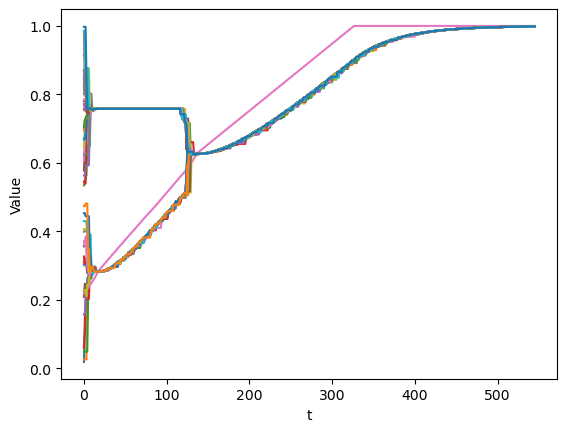

In [5]:
t_list = np.linspace(0, t, t + 1)
plt.plot(t_list, X)

# plt.title('Classic HK model')
plt.xlabel('t')
plt.ylabel('Value')
plt.show()

In [91]:
X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic(x0, eps, eps2, dyn_ind, prob)
t, cons_value, cons_time

(429, 0.4844984501189484, 72)

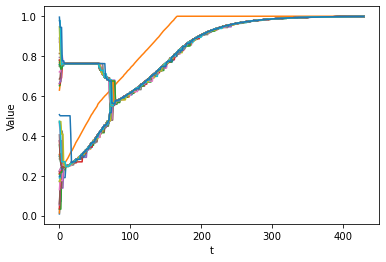

In [92]:
t_list = np.linspace(0, t, t + 1)
plt.plot(t_list, X)

# plt.title('Classic HK model')
plt.xlabel('t')
plt.ylabel('Value')
plt.show()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

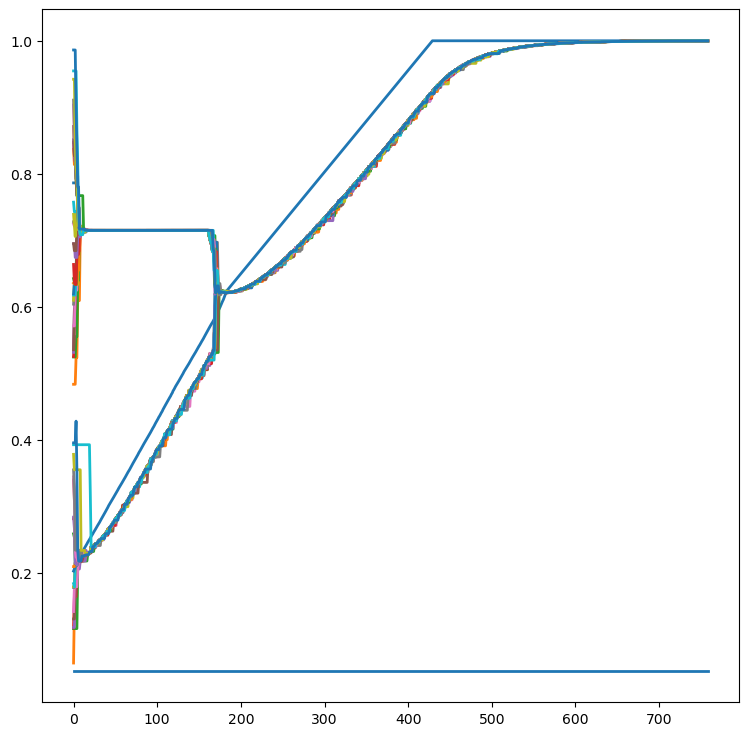

 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.14it/s]

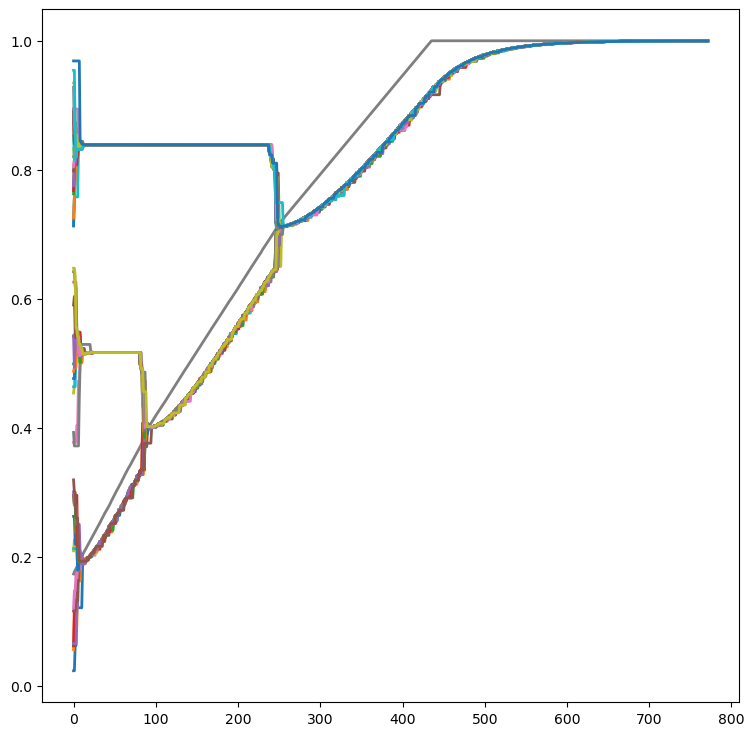

 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.09it/s]

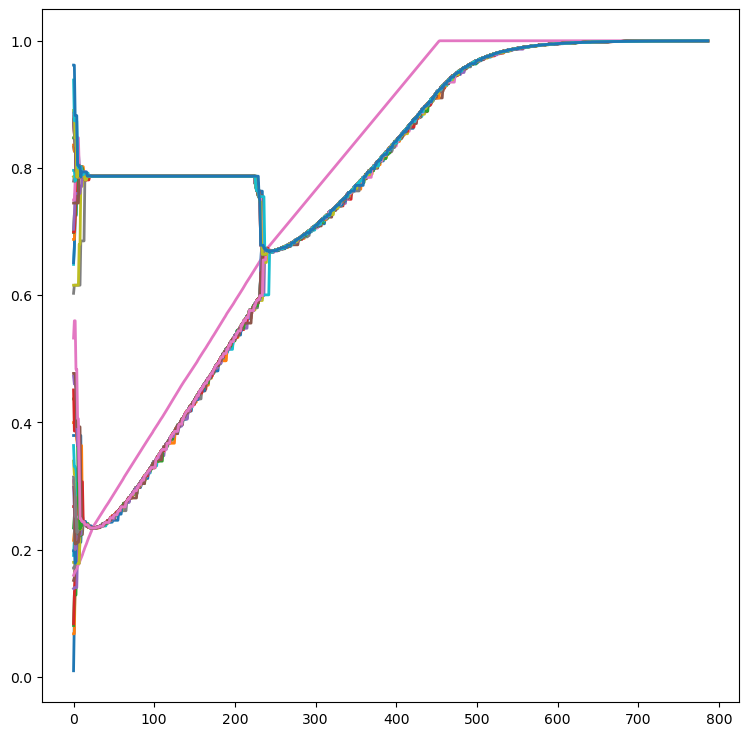

 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.10it/s]

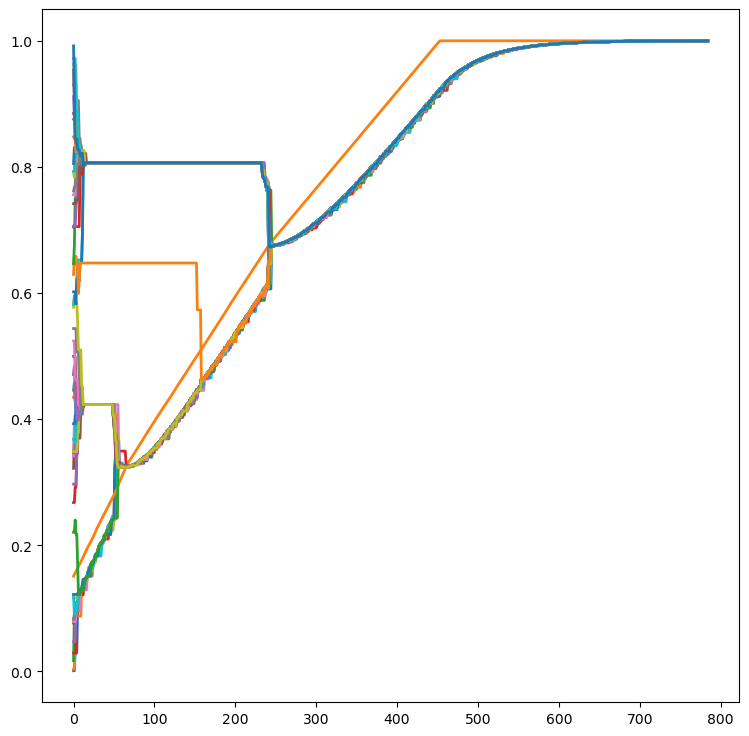

 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.09it/s]

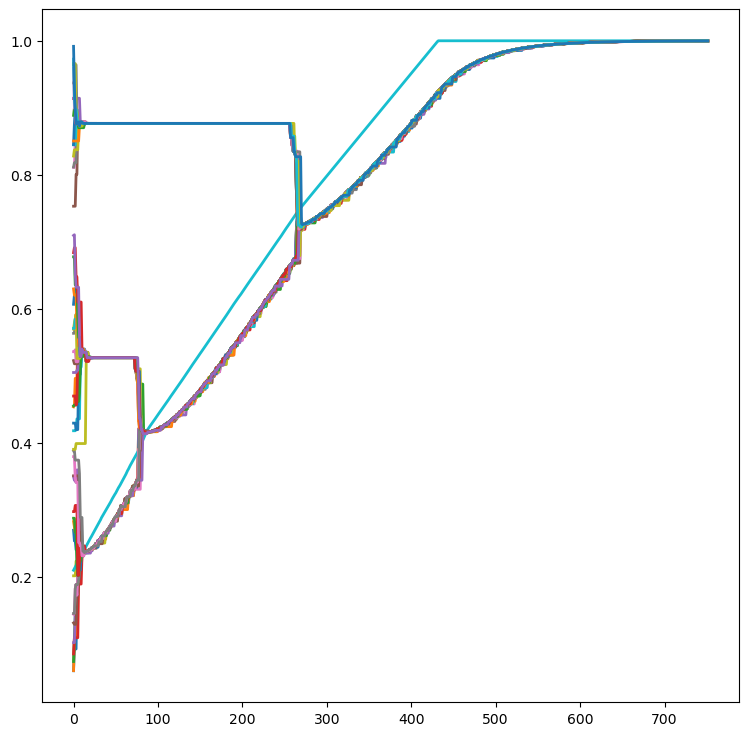

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.12it/s]

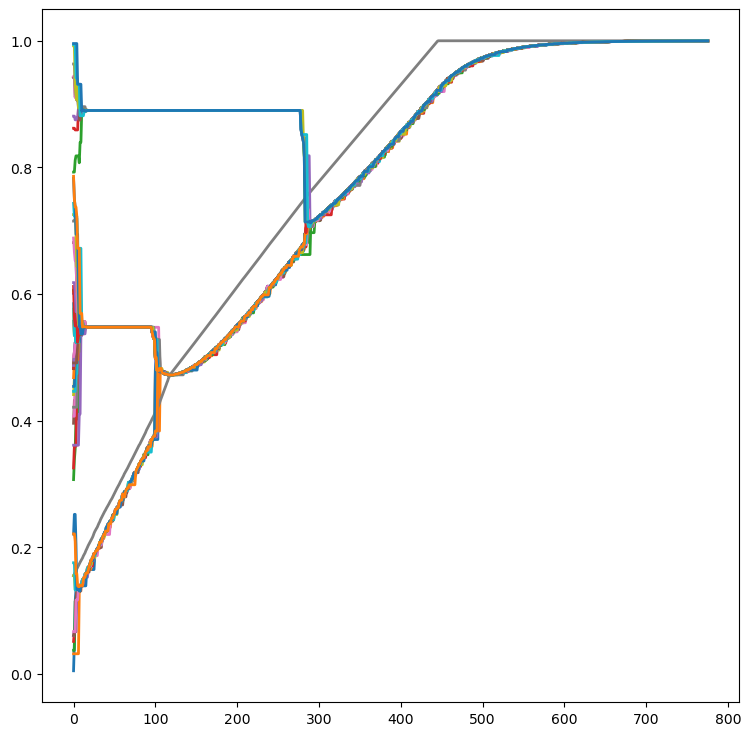

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.13it/s]

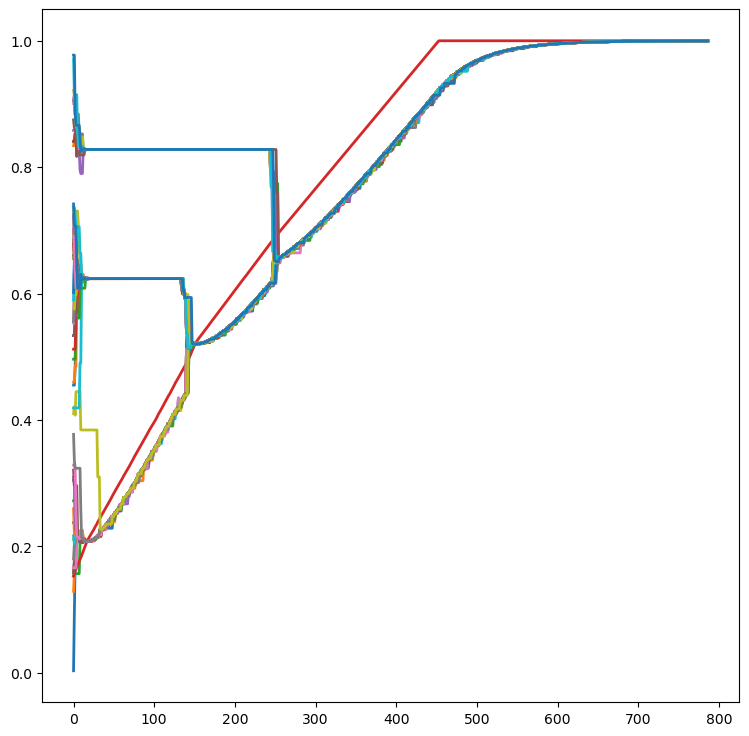

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

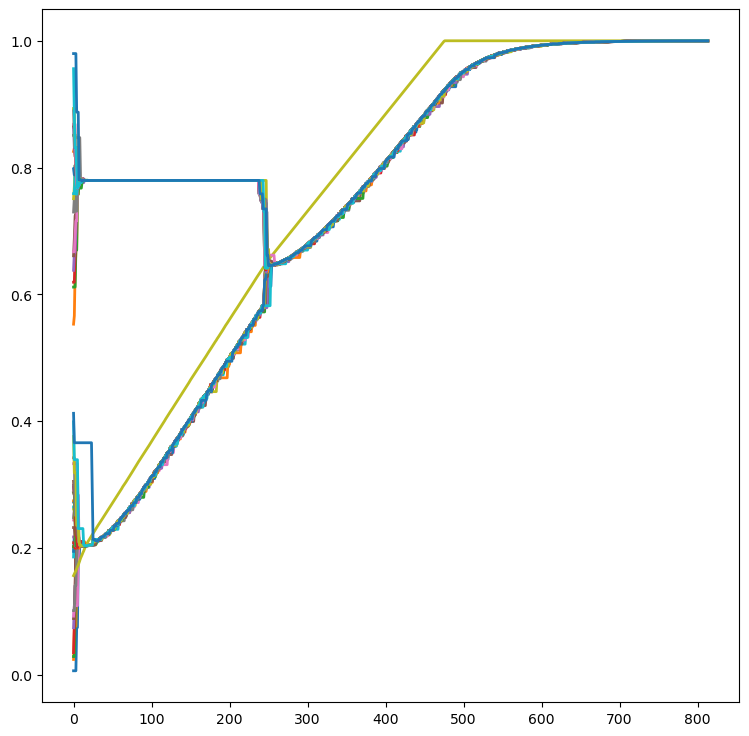

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.13it/s]

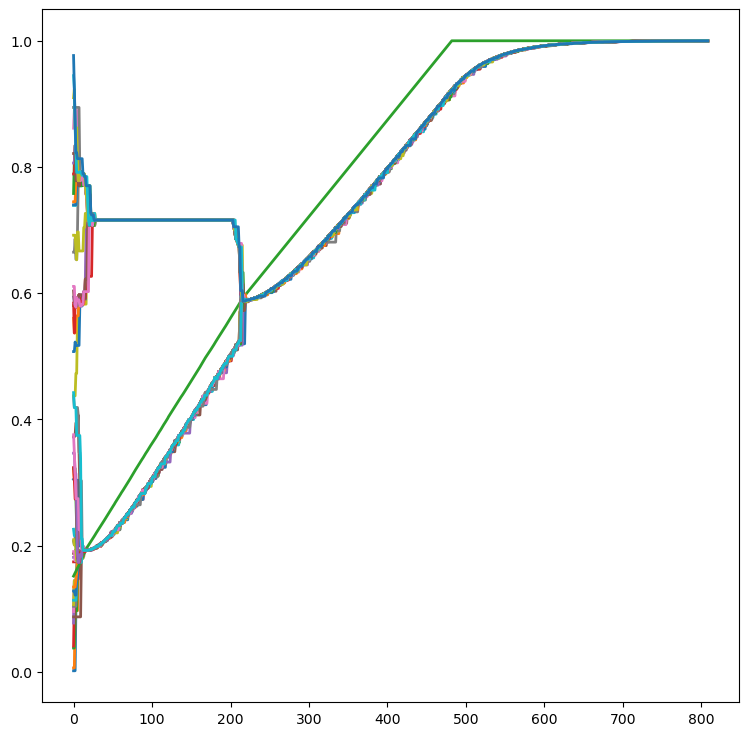

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:08<00:00,  1.12it/s]

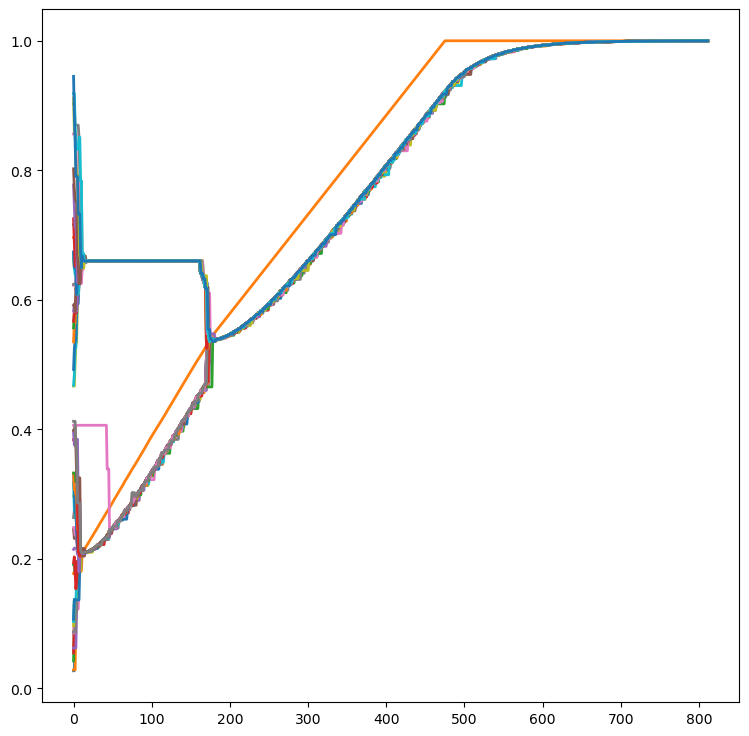

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]

Average evolution time: 784.3
Average consensus time: 240.55555555555554
Average consensus value in consensus time: 0.6375384993923855
Percentage of consensus: 0.9


In [10]:
eps = 0.15
eps2 = 1e-5
probe = 0.5
cons_value_data = np.asarray([])
cons_time_data = np.asarray([])
# positive_time_data = np.asarray([])
evolution_time = np.asarray([])
count_experiments = 10
# x0_massiv = np.assarray([])
count_consensus = 0

for i in trange(count_experiments):
    x0 = np.random.sample(n)
    x0.sort()
    spy_opinion = x0[0] + eps  # the lowest opinion + eps
    x0, dyn_ind = find_dynamic_index(x0, spy_opinion)
    X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, dyn_ind, probe)
#     cons_value_data = np.append(cons_value_data, cons_value)
    evolution_time = np.append(evolution_time, t)
#     cons_time_data = np.append(cons_time_data, cons_time)
#     positive_time_data = np.append(positive_time_data, positive_time)
    if cons_value > 0:
        count_consensus += 1
        cons_value_data = np.append(cons_value_data, cons_value)
        cons_time_data = np.append(cons_time_data, cons_time)
#     if cons_value < 0.4:
#         print(cons_value)
    t_list = np.linspace(0, t, t + 1)
    fig = plt.figure(facecolor='white', figsize=(9, 9))
    plt.plot(t_list, X, linewidth=2)
    plt.show()
print('Average evolution time:', np.mean(evolution_time))
print('Average consensus time:', np.mean(cons_time_data))
print('Average consensus value in consensus time:', np.mean(cons_value_data))
# print('Average time when consensus reached 0.6:', np.mean(positive_time_data))
# count_coin = 0.
# for i in range(count_consensus):
#     if cons_time_data[i] == positive_time_data[i]:
#         count_coin += 1
print('Percentage of consensus:', count_consensus / count_experiments)
# print('Percentage of consensus formation with value above 0.6:', count_coin / count_experiments)

In [97]:
eps = 0.2
eps2 = 1e-5
probe = 0.5
cons_value_data = np.asarray([])
cons_time_data = np.asarray([])
# positive_time_data = np.asarray([])
evolution_time = np.asarray([])
count_experiments = 1000
# x0_massiv = np.assarray([])
count_consensus = 0

for i in trange(count_experiments):
    x0 = np.random.sample(n)
    x0.sort()
    spy_opinion = x0[0] + eps  # the lowest opinion + eps
    x0, dyn_ind = find_dynamic_index(x0, spy_opinion)
    X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, dyn_ind, probe)
#     cons_value_data = np.append(cons_value_data, cons_value)
    evolution_time = np.append(evolution_time, t)
#     cons_time_data = np.append(cons_time_data, cons_time)
#     positive_time_data = np.append(positive_time_data, positive_time)
    if cons_value > 0:
        count_consensus += 1
        cons_value_data = np.append(cons_value_data, cons_value)
        cons_time_data = np.append(cons_time_data, cons_time)
#     if cons_value < 0.4:
#         print(cons_value)
#     t_list = np.linspace(0, t, t + 1)
#     fig = plt.figure(facecolor='white', figsize=(9, 9))
#     plt.plot(t_list, X, linewidth=2)
#     plt.show()
print('Average evolution time:', np.mean(evolution_time))
print('Average consensus time:', np.mean(cons_time_data))
print('Average consensus value in consensus time:', np.mean(cons_value_data))
# print('Average time when consensus reached 0.6:', np.mean(positive_time_data))
# count_coin = 0.
# for i in range(count_consensus):
#     if cons_time_data[i] == positive_time_data[i]:
#         count_coin += 1
print('Percentage of consensus:', count_consensus / count_experiments)
# print('Percentage of consensus formation with value above 0.6:', count_coin / count_experiments)

100%|██████████| 1000/1000 [09:07<00:00,  1.83it/s]

Average evolution time: 688.916
Average consensus time: 134.9046153846154
Average consensus value in consensus time: 0.5663460712713848
Percentage of consensus: 0.975


In [ ]:
eps = 0.25
eps2 = 1e-5
probe = 0.5
cons_value_data = np.asarray([])
cons_time_data = np.asarray([])
# positive_time_data = np.asarray([])
evolution_time = np.asarray([])
count_experiments = 1000
# x0_massiv = np.assarray([])
count_consensus = 0

for i in trange(count_experiments):
    x0 = np.random.sample(n)
    x0.sort()
    spy_opinion = x0[0] + eps  # the lowest opinion + eps
    x0, dyn_ind = find_dynamic_index(x0, spy_opinion)
    X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, dyn_ind, probe)
#     cons_value_data = np.append(cons_value_data, cons_value)
    evolution_time = np.append(evolution_time, t)
#     cons_time_data = np.append(cons_time_data, cons_time)
#     positive_time_data = np.append(positive_time_data, positive_time)
    if cons_value > 0:
        count_consensus += 1
        cons_value_data = np.append(cons_value_data, cons_value)
        cons_time_data = np.append(cons_time_data, cons_time)
#     if cons_value < 0.4:
#         print(cons_value)
#     t_list = np.linspace(0, t, t + 1)
#     fig = plt.figure(facecolor='white', figsize=(9, 9))
#     plt.plot(t_list, X, linewidth=2)
#     plt.show()
print('Average evolution time:', np.mean(evolution_time))
print('Average consensus time:', np.mean(cons_time_data))
print('Average consensus value in consensus time:', np.mean(cons_value_data))
# print('Average time when consensus reached 0.6:', np.mean(positive_time_data))
# count_coin = 0.
# for i in range(count_consensus):
#     if cons_time_data[i] == positive_time_data[i]:
#         count_coin += 1
print('Percentage of consensus:', count_consensus / count_experiments)
# print('Percentage of consensus formation with value above 0.6:', count_coin / count_experiments)

In [ ]:
eps = 0.3
eps2 = 1e-5
probe = 0.5
cons_value_data = np.asarray([])
cons_time_data = np.asarray([])
# positive_time_data = np.asarray([])
evolution_time = np.asarray([])
count_experiments = 1000
# x0_massiv = np.assarray([])
count_consensus = 0

for i in trange(count_experiments):
    x0 = np.random.sample(n)
    x0.sort()
    spy_opinion = x0[0] + eps  # the lowest opinion + eps
    x0, dyn_ind = find_dynamic_index(x0, spy_opinion)
    X, t, cons_value, cons_time = Hen_Kr_actm2_dynamic_speed_control_statistic_mod(x0, eps, eps2, dyn_ind, probe)
#     cons_value_data = np.append(cons_value_data, cons_value)
    evolution_time = np.append(evolution_time, t)
#     cons_time_data = np.append(cons_time_data, cons_time)
#     positive_time_data = np.append(positive_time_data, positive_time)
    if cons_value > 0:
        count_consensus += 1
        cons_value_data = np.append(cons_value_data, cons_value)
        cons_time_data = np.append(cons_time_data, cons_time)
#     if cons_value < 0.4:
#         print(cons_value)
#     t_list = np.linspace(0, t, t + 1)
#     fig = plt.figure(facecolor='white', figsize=(9, 9))
#     plt.plot(t_list, X, linewidth=2)
#     plt.show()
print('Average evolution time:', np.mean(evolution_time))
print('Average consensus time:', np.mean(cons_time_data))
print('Average consensus value in consensus time:', np.mean(cons_value_data))
# print('Average time when consensus reached 0.6:', np.mean(positive_time_data))
# count_coin = 0.
# for i in range(count_consensus):
#     if cons_time_data[i] == positive_time_data[i]:
#         count_coin += 1
print('Percentage of consensus:', count_consensus / count_experiments)
# print('Percentage of consensus formation with value above 0.6:', count_coin / count_experiments)